Home Credit Default Risk(Solution1)
====================
#### Can you predict how capable each applicant is of repaying a loan?

##### Reference : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

0 Understand the problem and the data
-----

#### 0.1 데이터 파일과 컬럼 내용 파악하기 
#### 0.2 평가 지표 확인하기
- 대회에서 어떤 평가지표(roc-auc,f1 등)를 사용하지는 확인하기

In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

1 Read in Data, Data Cleaning and formatting
-------

#### 1.1 데이터 파일과 컬럼 내용 출력해서 확인해보기
#### 1.2 train, test set 각각 읽어들이고 shape, head 확인해보기

In [88]:
# 주어진 데이터 파일이 어떤 게 있는지 확인하기
print(os.listdir('data/'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [89]:
# 데이터 읽어들이고 형태, 개략적인 내용 확인하기
app_train = pd.read_csv('data/application_train.csv')
print('Training data shape :', app_train.shape)
app_train.head()

Training data shape : (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# test data 확인해보기
app_test = pd.read_csv('data/application_test.csv')
print('Testing data shape :', app_test.shape)
app_test.shape

Testing data shape : (48744, 121)


(48744, 121)

2 Explanatory Data Analysis
--------

#### 2.1 Examine the distribution of the target column
- 수로 나타내보고, 시각화해봐서 확인해보기
- unbalanced 문제 해결 방법 : http://www.chioka.in/class-imbalance-problem/

In [91]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

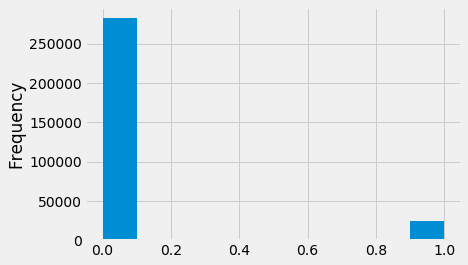

In [92]:
# From this information, we see this is an imbalanced class problem. 
# There are far more loans that were repaid on time than loans that were not repaid. 
app_train['TARGET'].astype(int).plot.hist()

#### 2.2 Examine Missing Values
- missing value 확인해보기
- 나중에 Imputer를 사용해 missing values를 채워야 한다.
      하지만 XGBoost는 imputer 방식 없이도 missing value를 처리할 수 있다. 
- 너무 많은 missing value를 가지고 있는 column은 drop해줄 수 있다. 
- 어떤 column이 유용한지 모르므로 일단 가지고 있는다. 

In [93]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 
                   1 : '% of Total Values'}
    )
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
    print('Your selected dataframe has ' + str(df.shape[1]) + 'columns.\n'
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
         ' columns that have missing values.')
    
    return mis_val_table_ren_columns

In [94]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


#### 2.3 Column Types
- int64, float64(수치형), object(string or categorical)
- 데이터 타입별 컬럼 수 확인
- object column 각각에 별개의 값이 몇 개 있는지 확인

In [95]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [96]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

#### 2.4 Encoding Categorical Variables
- Label Encoding : 레이블이 임의로 배정됨, categorical value가 단 두 개(남/여)일 뿐일 때는 잘 먹히나 그렇지 않을 시에는...
- One-Hot Encoding : categorical value를 잘 표현함, 레이블 수가 크게 증가하는 문제가 있으나 PCA로 해결할 수 있음
- 여기서는 2개의 category에는 Label Encoding을, 2개 이상의 category에는 One-Hot Encoding을 사용하기로 한다. 

In [97]:
# Label Encoding
le = LabelEncoder()
le_count = 0


for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [98]:
# One-Hot Encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape :', app_train.shape)
print('Testing Features shape :', app_test.shape)

Training Features shape : (307511, 243)
Testing Features shape : (48744, 239)


#### 2.5 Aligning Training and Testing Data
- train set과 test set에 같은 수의 feature가 있어야 한다. 하지만 One-Hot Encoding으로 인해 두 수가 같지 않다. 따라서 align을 진행해줘야 한다.(axis=1로 설정해 column에 적용!)

In [99]:
# Note 2.5 참고
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis=1)

app_train["TARGET"] = train_labels

print('Training Features shape :', app_train.shape)
print('Testing Features shape :', app_test.shape)

Training Features shape : (307511, 240)
Testing Features shape : (48744, 239)


#### 2.6 Deal with Anomalies
- DAY_BIRTH column은 현재에 시점을 기준으로 작성되었기 때문에 음수 값을 가지고 있다. 
- 이상치 처리는 상황에 따르나 일반적으로 missing value로 처리한 후 머신러닝을 적용하기 전에 Imputation을 진행한다. 
- 하지만 현재 DAYS_EMPLOYED column은 중요한 정보를 담고 있으므로 다른 값으로 채워주기로 함
- test set에도 마찬가지로 적용

In [100]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [101]:
# 노동 일수가 365243일???
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

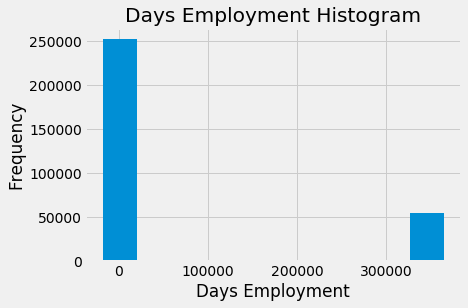

In [102]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

In [103]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


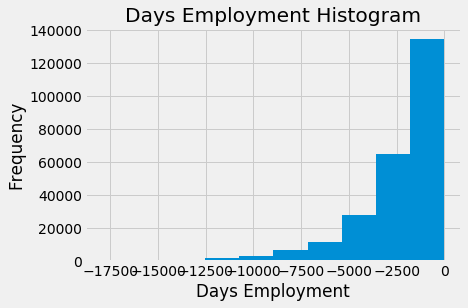

In [104]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [105]:
# 이상치가 있는 row만 True를 반환하게 됨
app_train['DAYS_EMPLOYED_ANOM']

0         False
1         False
2         False
3         False
4         False
          ...  
307506    False
307507     True
307508    False
307509    False
307510    False
Name: DAYS_EMPLOYED_ANOM, Length: 307511, dtype: bool

In [106]:
# test set에도 마찬가지로 적용
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


#### 2.7 Correlations
- variable과 target 사이의 상관관계 파악
- 참고 
.00-.19 “very weak”  
.20-.39 “weak”  
.40-.59 “moderate”  
.60-.79 “strong”  
.80-1.0 “very strong”  
- 고객의 나이가 가장 큰 양의 상관관계를 가짐(하지만 나이는 음수 값이므로 절대값 수치 확인이 필요하다)
- 중요한 column은 시각화 해보기
- kde plot이 target에 미치는 column의 영향을 확인하기에 좀 더 용이하다. 
- 나이의 경우 구간으로 나눠 상환률을 확인하는 방법이 있다. 
- Pairplot은 여러 변수들 간의 관계를 확인하기 유용하다

##### 2.7.1 Effect of Age on Repayment

In [107]:
# 고객의 나이가 가장 
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations : \n', correlations.tail(15))
print('\nMost Negative Correlations : \n', correlations.head(15))

Most Positive Correlations : 
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Nega

In [108]:
# Effect of Age on Repayment
# 나이들수록 대출 상환을 더 잘한다.
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Text(0, 0.5, 'Count')

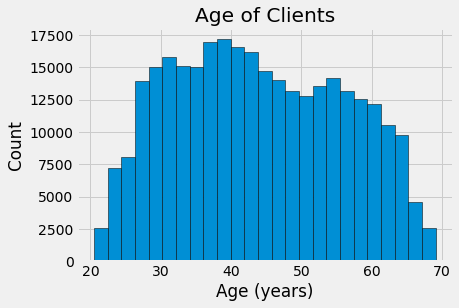

In [109]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Clients')
plt.xlabel('Age (years)')
plt.ylabel('Count')

Text(0.5, 1.0, 'Distribution of Ages')

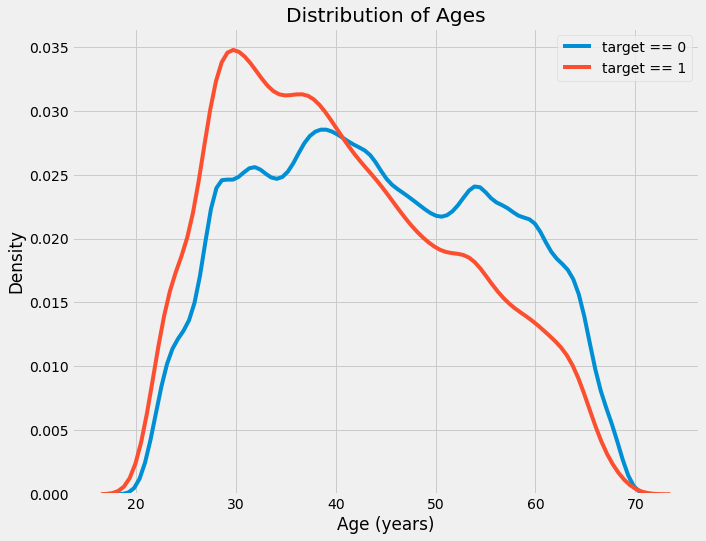

In [110]:
# target == 1이 나이 어린 쪽에 치우쳐저 있다.
plt.figure(figsize=(10,8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

In [111]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365 # 나이

# 나이를 5개의 구간마다 나눔
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [112]:
# 나이 구간별 평균
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

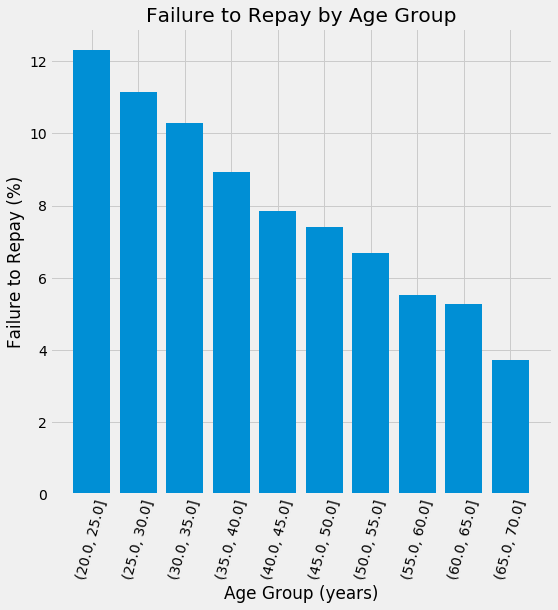

In [113]:
# 나이 구간별 상환 실패율
# 어린 놈들이 상환률이 더 낮음!
plt.figure(figsize=(8,8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

##### 2.7.2 Exterior Sources

In [114]:
# target과 음의 상관관계가 있던 feature들 살펴보기
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1, 'Correlation Heatmap')

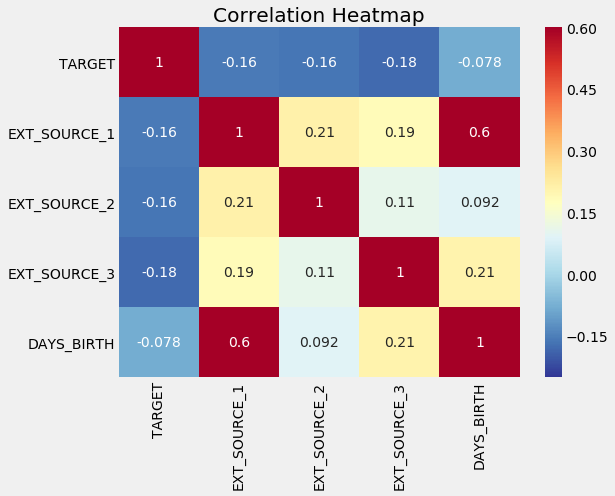

In [115]:
# 모든 ext value는 target과 음의 상관관계에 있다
# ext value가 높을수록 고객은 대출을 상환할 가능성이 더 높다
plt.figure(figsize=(8,6))

sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

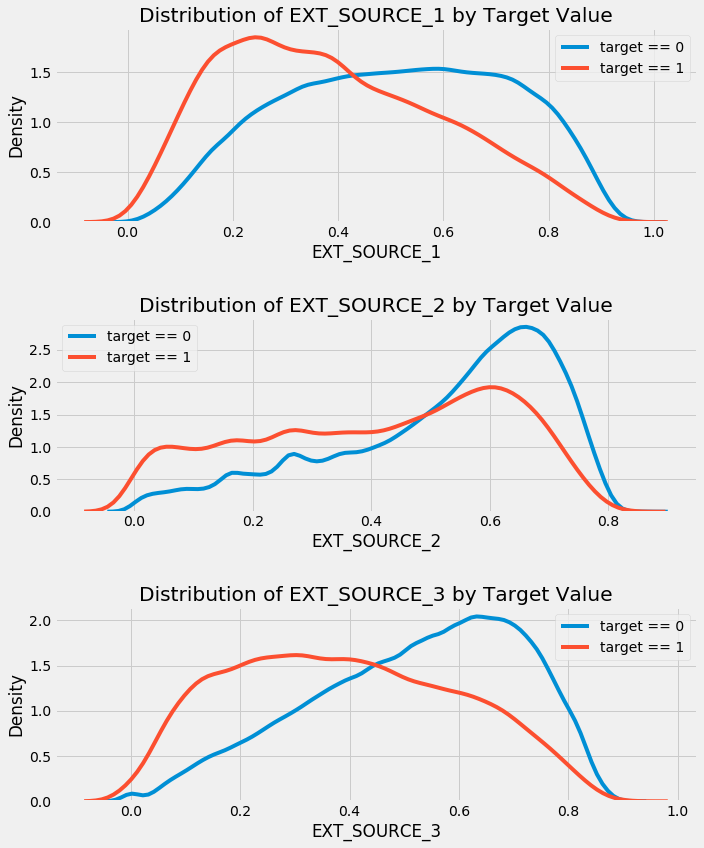

In [116]:
# EXT_SOURCE_3이 target과 가장 큰 차이를 보인다. 
# 약한 상관관계지만 머신러닝 모델에 유용한 정보를 제공한다. 
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source].dropna(), label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source].dropna(), label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

##### 2.7.3 Pair Plot

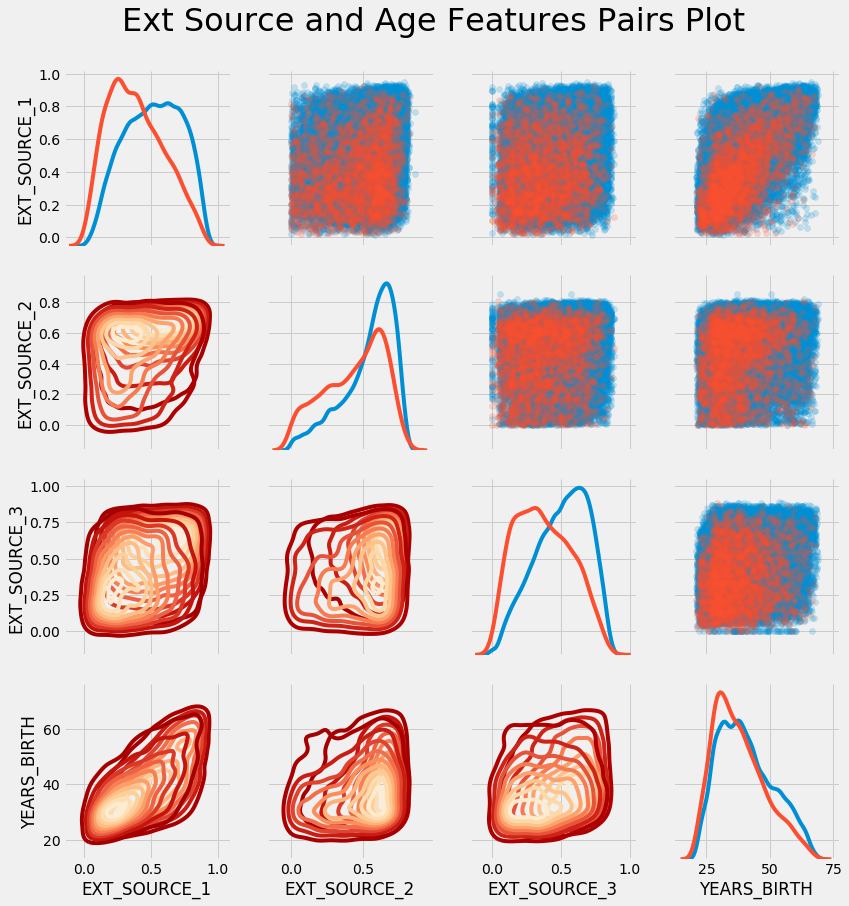

In [117]:
# BIRTH랑 EXT1과 양의 상관관계를 가진다. 

# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

3 Feature Engineering
-------------

- Feature engineering에는 새로운 feature를 만들어내거나 feature를 select하는 과정이 포함되어 있다.
- Good column to read : https://blog.featurelabs.com/secret-to-data-science-success/
- automated tools : https://docs.featuretools.com/getting_started/install.html
- Polynominal Features : 현재 있는 feauture의 제곱 값과 여러 개별 variable의 조합인 interaction term을 생성한다.  
  개별 특성은 큰 영향이 없을지라도 특성의 조합으로 target에 큰 영향을 줄 수 있다.   
  너무 크게 degree를 설정하면 안된다(overfitting문제 발생)

#### 3.1 Polynominal Features

In [118]:
# polynominal을 적용할 feature들 추출
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

# target value 제거해주기
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
# note 3.1 참고
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [119]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [120]:
# 새롭게 생성된 feature 이름 확인해보기
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [121]:
# 몇몇 feature들은 target과 오리지널보다 더 큰 상관관계를 보임
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10), '\n')
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64 

DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [122]:
# train, test set 에 합쳐주기!
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


#### 3.2 Domain Knowledge Features

In [123]:
# CREDIT_INCOME_PERCENT, ANNUITY_INCOME_PERCENT, CREDIT_TERM, DAYS_EMPLOYED_PERCENT 특성 만들어내기
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [124]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

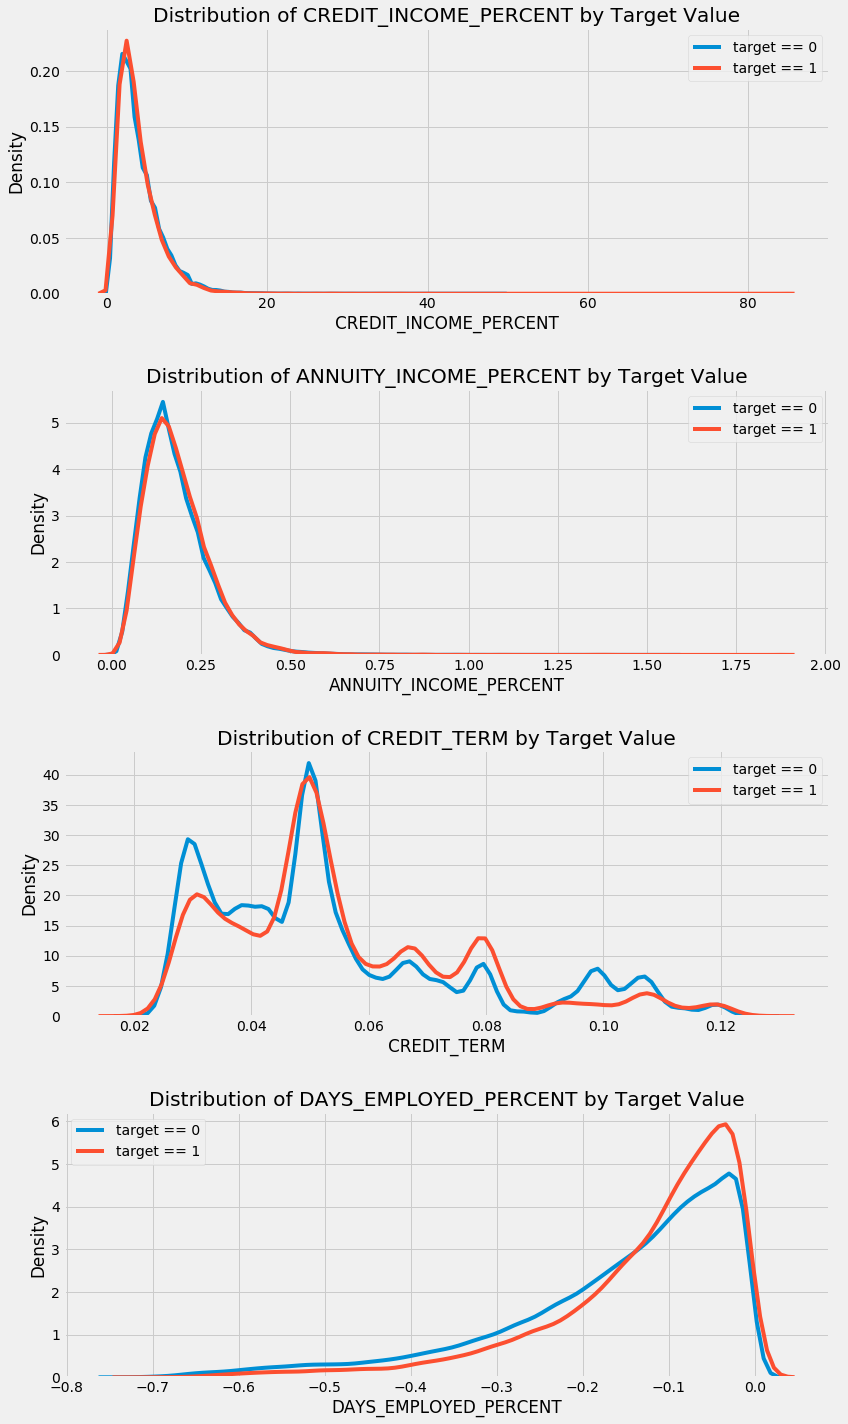

In [125]:
# 시각화해보기
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature].dropna(), label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature].dropna(), label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

4 Baseline
--------

#### 4.1 Preprocessing data
- target value를 train set에서 제외시키기
- encoding categorical variables
- filling missing values(imputation)
- normalizing the range of the features(feature scaling)

In [128]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# target value를 train set에서 제외시키기
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# feature name 
features = list(train.columns)

# copy the testing data
test = app_test.copy()

# fill missing values with median values
imputer = Imputer(strategy='median')

# scale each feature
scaler = MinMaxScaler(feature_range = (0, 1))

# fit on the training data
imputer.fit(train)

# transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# scaler too
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape :', train.shape)
print('Testing data shape :', test.shape)

Training data shape : (307511, 240)
Testing data shape : (48744, 240)


#### 4.2 Logistic Regression
- C는 regularization parameter로 overfitting 정도를 조정한다.    
  (C가 낮을수록 overftting을 줄인다)  
  (예상 확률을 원할 경우 predict_proba 메서드를 사용, 합이 1)  
- submission 형식에 맞추기

In [129]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [130]:
# make prediction
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [131]:
# submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.087750
1,100005,0.163957
2,100013,0.110238
3,100028,0.076575
4,100038,0.154924


In [132]:
# save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index=False)

5 Improved Model
    ---------------

#### 5.1 Random Forest
- feature importances 추출하기  
- 제출해보기

In [134]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100,
                                      random_state = 50,
                                      verbose = 1, 
                                      n_jobs = -1) # n_jobs : the number of jobs to run in parallel for both fit and predict
                                                   # -1 means using all processors

In [135]:
# train on the training data
random_forest.fit(train, train_labels)

# extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature' : features,
                                   'importance' : feature_importance_values})

# make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


In [136]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

#### 5.2 Make Predictions using Engineered Features

- poly feature에 대해 impute, scaling 진행하고 train하기   
  -> 결과 보니까 별로 도움안 됨...
- domain feature에 대한 검사  
  -> 별로 도움 안되보이지만 boosting 모델에선 좋은 결과 보임 

##### 5.1.2 Testing on Poly features

In [141]:
poly_features_names = list(app_train_poly.columns)

# impute
imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# scale
scaler = MinMaxScaler(feature_range=(0,1))

poly_features = scaler.fit_transform(poly_features)
poly_feature_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators=100,
                                           random_state=50,
                                           verbose=1,
                                           n_jobs=-1)

In [139]:
# train
random_forest_poly.fit(poly_features, train_labels)

# predict
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [140]:
# make submission
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_engineered.csv', index=False)

##### 5.2.2 Testing on Domain features

In [142]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


6 Model Interpretation
    -------------

#### 6.1 Feature Importances
- 어떤 feature가 중요한지 살펴볼 수 있음  
  engineer한 feature들이 TOP15 안에 들음  

In [143]:
def plot_feature_importances(df):
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

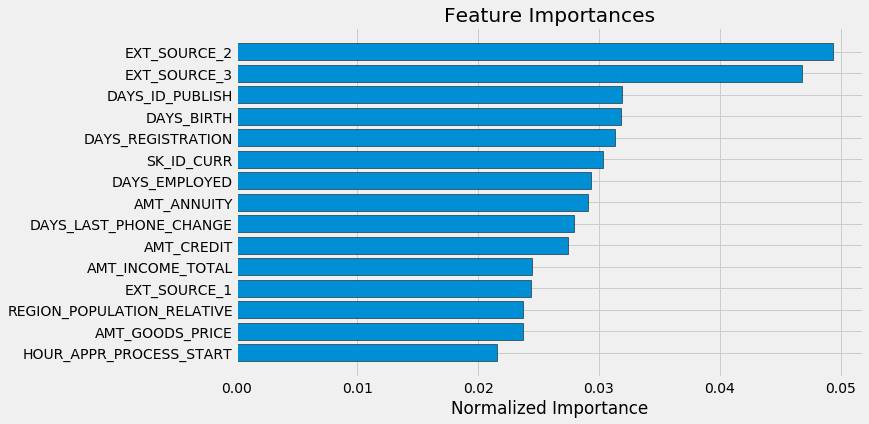

In [144]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)